## Visualizing your Wordpress posts in NetworkX and D3 

For the past several months I've been storing my academic notes on wordpress.com, with tags (e.g. birdsong, language acqusition, neural networks), and categories (e.g. papers, meeting-notes, tutorials). In writing the paper I wanted a way to visualize how these posts were connected so that I could look through my notes based on my current writing. I went through a few iterations of this and D3 is what I converged upon. I know almost nothing about javascript, so this post is essentially the joining together of three excellent tutorials:
- http://bl.ocks.org/mbostock/4062045
- http://www.coppelia.io/2014/07/an-a-to-z-of-extra-features-for-the-d3-force-layout/
- https://github.com/stitchfix/d3-jupyter-tutorial


There are still a number of improvements that need to be made:
- Linking to posts
- Displaying more info about the post on selection, hover
- Displaying 'most similar posts' rather than just choosing the first 5 connections

In [1]:
# basics
from IPython.core.display import display, HTML
from string import Template
import pandas as pd
import json, random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Things you'll probably need to download
import networkx as nx # for our first graph visualization
from networkx.readwrite import json_graph
import wxr_parser # parses the xml, download here: https://pypi.python.org/pypi/wxr-parser/0.1

Parse the XML output from wordpress. I grabbed example data from wordpress.org: https://codex.wordpress.org/Theme_Unit_Test

In [3]:
parsed_data = wxr_parser.parse(
    'data/theme-unit-test-data.xml'
)

### First we'll visualize the posts in NetworkX

In [4]:
G=nx.Graph()
filtered_entries = []

In [5]:
for i in range(len(parsed_data['posts'])):
    if len(parsed_data['posts'][i]['categories']) > 0:
        if len(parsed_data['posts'][i]['tags']) > 0:
            if parsed_data['posts'][i]['slug'] != None:
                entry = {}
                entry['slug'] = parsed_data['posts'][i]['slug']
                entry['title'] = parsed_data['posts'][i]['title']
                entry['categories'] = parsed_data['posts'][i]['categories']
                entry['tags'] = parsed_data['posts'][i]['tags']
                entry['link'] = parsed_data['posts'][i]['link']
                filtered_entries.append(entry)
                G.add_node(parsed_data['posts'][i]['slug'], type = parsed_data['posts'][i]['categories'][0])


In [6]:
edge_weights = []
# Adds node connections with weights based upon 
for i in range(len(filtered_entries)):
    node_i = filtered_entries[i]['slug']
    for j in range(i,len(filtered_entries)):
        node_j = filtered_entries[j]['slug']
        if node_i != node_j:
            #if nx.has_path(G,node_i, node_j) == False:
            weight = np.sum(
                [tag in filtered_entries[i]['tags'] for tag in filtered_entries[j]['tags']]    
            )
            if weight > 0:
                G.add_edge(node_i, node_j, weight=weight)
                edge_weights = np.append(edge_weights,weight)


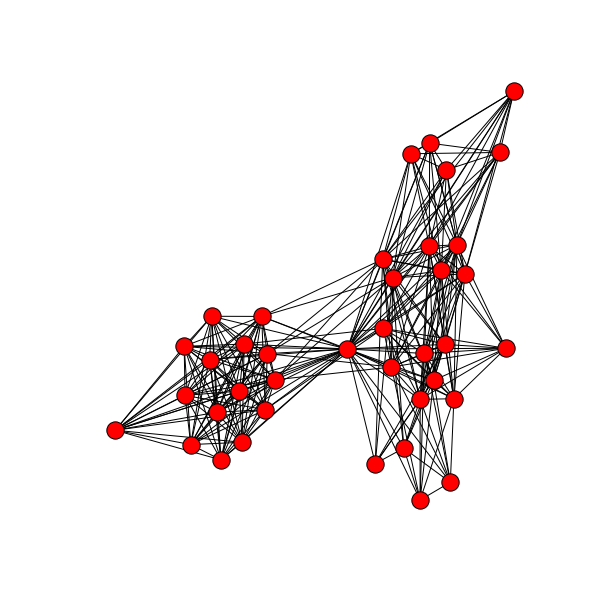

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,10))
nx.draw(G)

### Now we'll create a json to put this into D3

In [8]:
graph_data = { 'nodes': [], 'links': [] }

In [9]:
categories = []

In [10]:
i = 0
for node in G.nodes():
    cat = [a['categories'][0] for a in filtered_entries if a['slug'] == node][0]
    if cat in categories:
        cat_num = np.where(cat == categories)[0][0]
    else:
        cat_num = len(categories)
        categories = np.append(categories,cat)
    graph_data['nodes'].append({
            "name": node,
            "group": cat_num

        })
    i += 1

In [11]:
j = 0
for edge in G.edges():
    #print edge[1]
    source = np.where([node['name'] == edge[0] for node in graph_data['nodes']])[0][0]
    target = np.where([node['name'] == edge[1] for node in graph_data['nodes']])[0][0]
    graph_data['links'].append({
        "source" : source,
        "target" : target,
        "value" : edge_weights[j]
    })
    j += 1

In [12]:
with open('data/network.json', 'w') as fp:
    json.dump(graph_data, fp, sort_keys=True,indent=4)

### Now we load up our javascript libraries.

In [13]:
HTML('''
<script src="js/d3.min.js"></script>
<script type='text/javascript' src="js/jquery-3.1.0.min.js"></script>
<script type='text/javascript' src="https://code.jquery.com/ui/1.11.0/jquery-ui.min.js"> </script>
<script type='text/javascript' src="https://code.jquery.com/ui/1.11.0/themes/smoothness/jquery-ui.css"> </script>
<script src="js/d3.tip.v0.6.3.js"> </script>
''')

### Read our JSON back in 
Probably you can find a better way of doing this than writing a json and reading it back, but I'm lazy. 

In [14]:
with open('data/network.json') as data_file:    
    data = json.load(data_file)

In [15]:
# Add the JSON as HTML to this page
HTML(''.join(['<script type="application/json" id="mis">',json.dumps(data),'</script>']))

####  Style our post with CSS

In [16]:
css_text = '''
.node {
    stroke: #fff;
    stroke-width: 1.5px;
}
.link {
    stroke: #999;
    stroke-opacity: .6;
}
h3#slider {
    color: #1ABC9C;
    text-align:center;  
    font-style: italic;
    font-size: 14px;
    font-family: "Helvetica";
}
input[type=range] {
  width:150px;
  display: inline;
}
svg {
background: #e5e6ec
}
.d3-tip {
    line-height: 1;
    color:#000;
    position: relative;
    z-index:1000;
    background-color: rgba(255, 255, 255, 0.7);
    padding:10px;
    border-style: solid;
    border-width: 5px;
    border-color: rgba(255, 255, 255, 1);
    border-radius: 5px;
    font-size:15px;
}
#neighbors {
    color: #000;
    width: 300px;
    background: rgba(0,0,0,.1);
    border: 1px solid #000;
    margin-top: 30px;
}

#neighbors p {
    color: #000;
    border-top: 1px solid #000;
    padding: 3px 10px 3px 10px;
    margin: 0;
    font-weight: normal
}
p#similar-posts {
    font-size:14px;
    font-weight:bold;
    text-align:center
}
'''

### Now we insert the javascript

In [17]:
js_text_template = Template('''
var width = 960,
    height = 800;

//Set up the colour scale
var color = d3.scale.category20();

//Set up the force layout
var force = d3.layout.force()
    .charge(-200)
    .linkDistance(80)
    .size([width, height]);

//Append a SVG to the body of the html page. Assign this SVG as an object to svg
var svg = d3.select("#$graphdiv").append("svg")
    .attr("width", width)
    .attr("height", height);

//---Insert------
//Set up tooltip
var tip = d3.tip()
    .attr('class', 'd3-tip')
    .offset([-10, 0])
    .html(function (d) {
    return  d.name + "</span>";
})
svg.call(tip);
//---End Insert---

// Reads json file 
function readTextFile(file, callback) {
    var rawFile = new XMLHttpRequest();
    rawFile.overrideMimeType("application/json");
    rawFile.open("GET", file, true);
    rawFile.onreadystatechange = function() {
        if (rawFile.readyState === 4 && rawFile.status == "200") {
            callback(rawFile.responseText);
        }
    }
    rawFile.send(null);
};
var mis = document.getElementById('mis').innerHTML;
graph = JSON.parse(mis);
graphRec=JSON.parse(JSON.stringify(graph)); //Add this line


//Creates the graph data structure out of the json data
force.nodes(graph.nodes)
    .links(graph.links)
    .start();

//Create all the line svgs but without locations yet
var link = svg.selectAll(".link")
    .data(graph.links)
    .enter().append("line")
    .attr("class", "link")
    .style("stroke-width", function (d) {
    return Math.sqrt(d.value);
});

//Do the same with the circles for the nodes - no 
var node = svg.selectAll(".node")
    .data(graph.nodes)
    .enter().append("circle")
    .attr("class", "node")
    .attr("r", 8)
    .style("fill", function (d) {
    return color(d.group);
})
    .call(force.drag) // 
    .on('click', connectedNodes) //Added code 
    .on('mouseover', tip.show) //Added
    .on('mouseout', tip.hide); //Added


//Now we are giving the SVGs co-ordinates - the force layout is generating the co-ordinates which this code is using to update the attributes of the SVG elements
force.on("tick", function () {
    link.attr("x1", function (d) {
        return d.source.x;
    })
        .attr("y1", function (d) {
        return d.source.y;
    })
        .attr("x2", function (d) {
        return d.target.x;
    })
        .attr("y2", function (d) {
        return d.target.y;
    });

    node.attr("cx", function (d) {
        return d.x;
    })
        .attr("cy", function (d) {
        return d.y;
    });
    node.each(collide(0.5)); //Added 
});


var optArray = [];
for (var i = 0; i < graph.nodes.length - 1; i++) {
    optArray.push(graph.nodes[i].name);
}

optArray = optArray.sort();
$$(function () {
    $$("#search").autocomplete({
        source: optArray
    });
});

function searchNode() {
    //find the node
    var selectedVal = document.getElementById('search').value;
    var node = svg.selectAll(".node");
    if (selectedVal == "none") {
        node.style("stroke", "white").style("stroke-width", "5");
    } else {
        var selected = node.filter(function (d, i) {
            return d.name != selectedVal;
        });
        var not_selected = node.filter(function (d, i) {
            return d.name == selectedVal;
        });
        not_selected.attr("r", 15)
        selected.style("opacity", "0");
        
        var link = svg.selectAll(".link")
        link.style("opacity", "0");
        d3.selectAll(".node, .link").transition()
            .duration(1000)
            .attr("r", 8)
            .style("opacity", 1);
        //not_selected.connectedNodes()
    }
}

//---Insert-------

//adjust threshold

function threshold(thresh) {
    graph.links.splice(0, graph.links.length);

        for (var i = 0; i < graphRec.links.length; i++) {
            if (graphRec.links[i].value > thresh) {graph.links.push(graphRec.links[i]);}
        }
    
    linkedByIndex = {};
    for (i = 0; i < graph.nodes.length; i++) {
        linkedByIndex[i + "," + i] = 1;
    };
    // for each link
    for (var i = 0; i < graphRec.links.length; i++) {
            if (graphRec.links[i].value > thresh) {
                //  add this link
                linkedByIndex[graphRec.links[i].source.index + "," + graphRec.links[i].target.index] = 1;
                
            }
        }
        
    restart(); 

}


//Restart the visualisation after any node and link changes

function restart() {

    link = link.data(graph.links);
    link.exit().remove();
    link.enter().insert("line", ".node").attr("class", "link");
    node = node.data(graph.nodes);
    node.enter().insert("circle", ".cursor").attr("class", "node").attr("r", 5).call(force.drag);
    force.start();
    

    
}
//---End Insert---
var padding = 1, // separation between circles
    radius=8;
function collide(alpha) {
  var quadtree = d3.geom.quadtree(graph.nodes);
  return function(d) {
    var rb = 2*radius + padding,
        nx1 = d.x - rb,
        nx2 = d.x + rb,
        ny1 = d.y - rb,
        ny2 = d.y + rb;
    quadtree.visit(function(quad, x1, y1, x2, y2) {
      if (quad.point && (quad.point !== d)) {
        var x = d.x - quad.point.x,
            y = d.y - quad.point.y,
            l = Math.sqrt(x * x + y * y);
          if (l < rb) {
          l = (l - rb) / l * alpha;
          d.x -= x *= l;
          d.y -= y *= l;
          quad.point.x += x;
          quad.point.y += y;
        }
      }
      return x1 > nx2 || x2 < nx1 || y1 > ny2 || y2 < ny1;
    });
  };
}

function addp(str)
{
    var par = document.createElement('p');
    par.appendChild(document.createTextNode(str));

    document.getElementById('inner_neighbors').appendChild(par);
}


var neighbors_list = []
//Toggle stores whether the highlighting is on
var toggle = 0;
//Create an array logging what is connected to what
var linkedByIndex = {};
for (i = 0; i < graph.nodes.length; i++) {
    linkedByIndex[i + "," + i] = 1;
};
graph.links.forEach(function (d) {
    linkedByIndex[d.source.index + "," + d.target.index] = 1;
});
//This function looks up whether a pair are neighbours
function neighboring(a, b) {
    if (a.name != b.name) {
        if(linkedByIndex[a.index + "," + b.index]){
            //document.getElementById("neighbors").innerHTML += a.name
            if (a.index != b.index){
                if ($$.inArray(a.name, neighbors_list) == -1){
                    neighbors_list.push(a.name)
                }
                if ($$.inArray(b.name, neighbors_list) == -1){
                    neighbors_list.push(b.name)
                }  
            }
    }
    }
    return linkedByIndex[a.index + "," + b.index];
}


function connectedNodes() {
    if (toggle == 0) {
        //Reduce the opacity of all but the neighbouring nodes
        d = d3.select(this).node().__data__;
        neighbors_list = []
        node.style("opacity", function (o) {
            return neighboring(d, o) | neighboring(o, d) ? 1 : 0.2;
        });
        link.style("opacity", function (o) {
            return d.index==o.source.index | d.index==o.target.index ? 1 : 0.2;
        });
        //Reduce the op
        
        if (neighbors_list.length > 5) {
            var short_list = neighbors_list.slice(0,4);
        } else {
            var short_list = neighbors_list
        }
        
        short_list.forEach(addp);
        this.setAttribute("r", 12)
        document.getElementById("select_title_p").innerHTML = d.name
        toggle = 1;
    } else {
        //Put them back to opacity=1
        node.style("opacity", 1);
        link.style("opacity", 1);
        d3.selectAll(".node").transition()
            .duration(200)
            .attr("r", 8)
        document.getElementById("select_title_p").innerHTML = 'Select a node'
        document.getElementById("inner_neighbors").innerHTML = ''
        toggle = 0;
    }
}

$$(function() {
    $$("#neighbors").draggable();
});
''')

### And finally we embed all that in our HTML output.

In [18]:
html_template = Template('''
<style> $css_text </style>
<div class="ui-widget" style="float:left;padding:10px">
   <input id="search">
    <button type="button" onclick="searchNode()">Search</button>
</div>
<div style="float:right;padding:10px">
<form>
    <h3 id="slider"> Link threshold 0 <input type="range" id="thersholdSlider" name="points" value = 0 min="0" max="10" onchange="var linkedByIndex = threshold(this.value)"> 10 </h3>
</form>
</div>
<div style="position: relative; width: 0; height: 0;float:right;margin-top: 50px;    margin-right: 50px;">
<div id="neighbors">
<div id="select_title"><p id="select_title_p" style="font-weight: bold;">Select a node</p></div>
<div id="inner_neighbors"></div>
</div>
</div>
<div id="graph-div"></div>

<script> $js_text </script>
''')
js_text = js_text_template.substitute({'graphdiv': 'graph-div'})
HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))